# Тема 30. Простая нейронная сеть для распознавания рукописных цифр MNIST на Keras

Использованы [материалы](https://keras.io/examples/vision/mnist_convnet/) документации [Keras](https://keras.io/):

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2015/06/19<br>
**Last modified:** 2020/04/21<br>
**Description:** A simple convnet that achieves ~99% test accuracy on MNIST.

## Подключение
Сначала подключим все необходимые библиотеки, numpy, keras из tensorflow и слои layers из него. Не пугайтесь предупреждений Warning, они ничего не испортят.

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

## Подготовка данных
Сначала нужно подготовить все необходимые данные, к счастью данные об изображениях рукописных цифр и их названий уже есть в Keras, загрузим их командой `keras.datasets.mnist.load_data()`. Это займет некоторое время.

In [2]:
# Гиперпараметры модели
num_classes = 10 # число классов - число цифр
input_shape = (28, 28, 1) # размер изображений цифр, они не цветные, поэтому канал 1.

# загружаем данные (изображения и их классы), отдельно обучающие и тестовые
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() #

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
# это массивы numpy, посмотрите их размеры
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


Изображения - массивы целых чисел от 0 до 255, для обучения их нужно перевести в числа с плавающей точкой (float) в диапазон [0 , 1]


In [4]:
# Преобразуем во float и диапазон [0, 1]
x_train = x_train.astype("float32") / 255 #
x_test = x_test.astype("float32") / 255 #
# на всякий случай принудительно сделаем размер (28, 28, 1)
x_train = np.expand_dims(x_train, -1) # для обучающих
x_test = np.expand_dims(x_test, -1) # для тестовых
print("x_train shape:", x_train.shape) # размер массива
print(x_train.shape[0], "train samples") # число примеров обучения
print(x_test.shape[0], "test samples") # число примеров теста

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Для классификации нужно как-то закодировать классы. Самый распространенный способ - бинарное кодирование (по-английски one-hot encoding), когда класс кодируется вектором (или строкой) из нулей и одной единички, положение единички показывает номер класса. Размер вектора равен числу классов. Пример для трех классов показан на рисунке: красный кодируется как (1 0 0), синий - (0 1 0), зеленый - (0 0 1).
.
![img](https://drive.google.com/uc?id=1mJSaXPnyc8fhUJ8-cWwFkhBljJKmt40b)

В нашем случае 10 классов, значит надо использовать 10-мерные вектора. Для этого есть вспомогательная функция `keras.utils.to_categorical`

In [5]:
# переводим метки классов в бинарные вектора 
y_train = keras.utils.to_categorical(y_train, num_classes) # обучающие
y_test = keras.utils.to_categorical(y_test, num_classes) # тестовые

In [6]:
print(y_train.shape) # размер массива
print(y_train[0]) # первый элемент его

(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## Создание нейронной сети
Надо указать какие слои есть в нейронной сети и параметры этих слоев, если нужны.
Мы строим простую сеть, в которой слои будут идти последовательно, для чего используется контейнер `keras.Sequential()` (но бывают сети с разветвленной структурой, для них по-другому).

In [8]:
# задаем последовательную модель
model = keras.Sequential( # слои перечисляются ниже
    [
        # слой входов (это не нейроны, а именно входы, т.е. данные), указываем размер shape
        keras.Input(shape=input_shape), 
        # первый сверточный слой, указываем число фильтров (32), размер ядра (3 на 3), функцию активации (relu)
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"), 
        # слой пулинга, не обучаемый, но позволит уменьшить размер. указываем размер ядра пулинга (2 на 2)
        layers.MaxPooling2D(pool_size=(2, 2)), #
        # второй сверточный слой, указываем число фильтров (64), размер ядра (3 на 3), функцию активации (relu)
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"), #
        # снова пулинг, после этого слоя размер массива выхода уже не большой
        layers.MaxPooling2D(pool_size=(2, 2)), #
        # слой "выпрямления", когда массив вытягивается в вектор, просто изменяет форму массива,
        # нужен чтобы массивы были подходящей размерности.
        layers.Flatten(), #
        # слой дропаута, будет при обучении случайно удалять связи, указываем вероятность удаления связи от 0 до 1 (0.5)
        layers.Dropout(0.5), #
        # полносвязный слой как в персептроне, размер его равен числу классов, функция активации softmax
        layers.Dense(num_classes, activation="softmax"), #
    ]
)

Посмотрим на созданную сеть, особенно обратите внимание на размерности массивов выхода и число обучающих параметров в слое (первый None относится к числу обучающих примеров, вход  не показан, функции активации не показаны).

In [9]:
model.summary() # информация о созданной сети

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

## Обучение сети
Сеть создана, теперь ее надо обучить. 

Необходимо указать какая используется функция ошибки, метод обучения и его параметры, метрика для проверки. 

Для задания параметров обучения используем метод `.compile()`.

Для обучения - метод `.fit()`. Здесь часть данных может быть использована для проверки (validation) работы сети, чтобы в случае если вдруг ошибка обобщения начала увеличиваться, то остановить процесс и не испортить уже достигнутой точности.

О возможных вариантах слоев, функций ошибки, методов обучения и метрик смотри [справку](https://keras.io/api/). 

Обучение - медленный процесс, ждите... 

In [10]:
batch_size = 128 # размер пакета (batch)
epochs = 15 # количество эпох обучения

# задаем функцию ошибки, метод обучения и метрику проверки
model.compile(
    loss="categorical_crossentropy", # кросс-энтропия, одна из возможных функций ошибки, часто используется для классификации
    optimizer="adam", # метод обучения Adam - модификация градиентного спуска
    metrics=["accuracy"]) # метрика accuracy
# запускаем обучение
model.fit(
    x_train, # входные обучающие данные
    y_train, # желаемые выходные данные (указания учителя)
    batch_size=batch_size, # размер пакета
    epochs=epochs, # максимальное число эпох обучения
    validation_split=0.1) # доля данных, отданных на проверку

Epoch 1/15
422/422 [==============================] - 40s 93ms/step - loss: 0.7429 - accuracy: 0.7710 - val_loss: 0.0830 - val_accuracy: 0.9773
Epoch 2/15
422/422 [==============================] - 39s 92ms/step - loss: 0.1161 - accuracy: 0.9650 - val_loss: 0.0545 - val_accuracy: 0.9858
Epoch 3/15
422/422 [==============================] - 39s 92ms/step - loss: 0.0821 - accuracy: 0.9743 - val_loss: 0.0461 - val_accuracy: 0.9890
Epoch 4/15
422/422 [==============================] - 45s 108ms/step - loss: 0.0750 - accuracy: 0.9759 - val_loss: 0.0421 - val_accuracy: 0.9880
Epoch 5/15
422/422 [==============================] - 39s 93ms/step - loss: 0.0632 - accuracy: 0.9812 - val_loss: 0.0368 - val_accuracy: 0.9907
Epoch 6/15
422/422 [==============================] - 39s 93ms/step - loss: 0.0569 - accuracy: 0.9827 - val_loss: 0.0374 - val_accuracy: 0.9905
Epoch 7/15
422/422 [==============================] - 39s 93ms/step - loss: 0.0485 - accuracy: 0.9842 - val_loss: 0.0333 - val_accuracy

## Проверка работы модели
Обучив сеть, давайте для тестовых данных, на которых мы не обучались, определим их классы и сравним с настоящими. Для этого используется метод `.evaluate()`

In [11]:
score = model.evaluate(x_test, y_test, verbose=0) # оцениваем нашу модель (verbose=0 подавляет вывод на экран)
print("Test loss:", score[0]) # функция ошибки на тестовых данных
print("Test accuracy:", score[1]) # метрика (из заданных, у нас accuracy) на тестовых данных


Test loss: 0.02545689232647419
Test accuracy: 0.9918000102043152


Все замечательно обучилось.

Давайте построим несколько картинок.

Чтобы рассчитать выход обученной сети по известному входу используем метод `.predict()`.
Он вернет нам вектор выхода. 

Если нам нужен номер класса, а не его вектор, то можно использовать метод `.predict_classes()`, но осторожно, эта функция почему-то не документирована.   

Это цифра [0]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


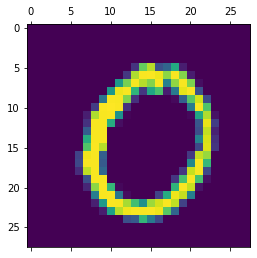

In [15]:
test_example=101 # индекс примера
test_input=x_test[test_example:test_example+1] # изображение этого примера
#test_output=model.predict(test_input)#
test_output=model.predict_classes(test_input)# распознанный класс для него
from matplotlib import pyplot as plt  # 
plt.matshow(test_input[0,:,:,0]) # рисуем матрицу как изображение. Для этой команды нужно подавать двумерный массив
print('Это цифра',test_output) # выводим номер класса, он же название цифры

# Задания
Изменяйте слои, их параметры, смотрите как это влияет на обучение. Например, удалите dropout слой.
